In [0]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from torchvision.datasets.utils import download_url
import tarfile

get = True
if get:
  # Dowload the dataset
  dataset_url = "http://files.fast.ai/data/cifar10.tgz"
  download_url(dataset_url, '.')

  # Extract from archive
  with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
      tar.extractall(path='./data')


Using downloaded and verified file: ./cifar10.tgz


In [3]:
  data_dir = './data/cifar10'

  print(os.listdir(data_dir))
  classes = os.listdir(data_dir + "/train")
  print(classes)

['models', 'labels.txt', 'test', 'train']
['bird', 'deer', 'ship', 'airplane', 'horse', 'frog', 'cat', 'truck', 'automobile', 'dog']


 ## We use the entire dataset for training


In [0]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

### Data Augmentation / transformations

In [0]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [0]:
# PyTorch datasets
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [0]:
from torch.utils.data import DataLoader

In [0]:
batch_size = 256

In [0]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, 
                      num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle=False, 
                      num_workers=8, pin_memory=True)

## Cool lets look at some batches of data

In [0]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
def show_batch(dl):
  for images, labels in dl:
      fig, ax = plt.subplots(figsize=(16, 16))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(make_grid(images[:10], 5).permute(1, 2, 0))
      break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


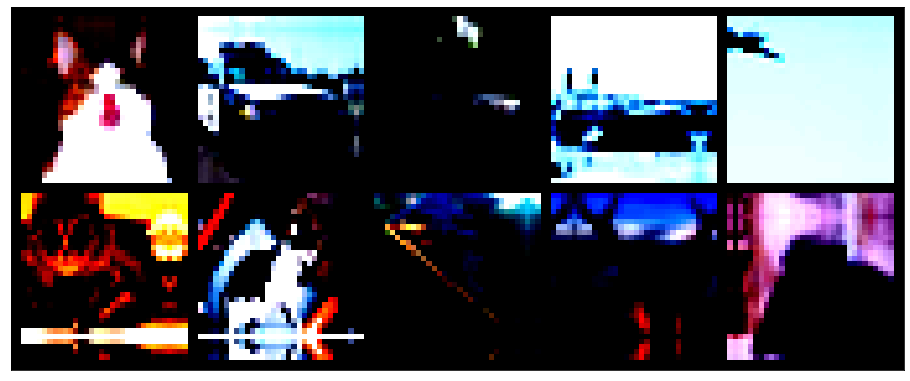

In [12]:
show_batch(train_dl)

## Building the model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 3, 3, 1, 1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(3, 3, 3, 1, 1)
    self.relu2 = nn.ReLU()
  
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.relu2(out + xb)
    return out

In [0]:
resnet_blk = SimpleResidualBlock()

In [16]:
for images, labels in train_dl:
  out = resnet_blk(images)
  print(out.shape)
  break


torch.Size([256, 3, 32, 32])


### Building the complete Resnet Model (implementation borrowed from FASTAI)
---
<img src="https://miro.medium.com/max/2500/1*gOyiFYGHMAEDlyoAIhkWkA.png" width=100%>


In [0]:
def conv_2d(ni, nf, stride=1, ks=3):
    return nn.Conv2d(in_channels=ni, out_channels=nf, 
                     kernel_size=ks, stride=stride, 
                     padding=ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                         nn.ReLU(inplace=True), 
                         conv_2d(ni, nf))

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)
    
    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [0]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1, N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()      
        # Increase channels to n_start using conv layer
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]
        
        # Add groups of BasicBlock(increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], 
                                 n_channels[i+1], stride)
        
        # Pool, flatten & add linear layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]), 
                   nn.ReLU(inplace=True), 
                   nn.AdaptiveAvgPool2d(1), 
                   Flatten(), 
                   nn.Linear(n_channels[3], n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self, x): return self.features(x)
    
def wrn_22(): 
    return WideResNet(n_groups=3, N=3, n_classes=10, k=6)

In [19]:
model = wrn_22()
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [20]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 10])


## Training the model with the help of FastAI API
---

In [0]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [0]:
data = DataBunch.create(train_ds, valid_ds, bs=batch_size, path='./data/cifar10')
learner = Learner(data, model, loss_func=F.cross_entropy, metrics=[accuracy])
learner.clip = 0.1

### Using the buiit in functionality of FastAI to find best Learning rate for our problem
----

In [23]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


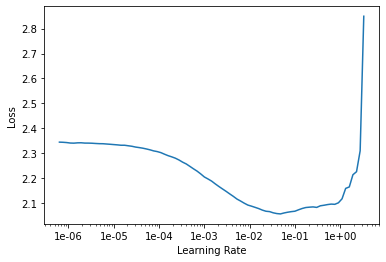

In [24]:
learner.recorder.plot()

## One cycle fitting is a concept introduced by FASTAI 
--- 
It means to do a cycle with two steps of equal lengths, one going from a lower learning rate to a higher one than go back to the minimum. The maximum should be the value picked with the Learning Rate Finder, and the lower one can be ten times lower. Then, the length of this cycle should be slightly less than the total number of epochs, and, in the last part of training, we should allow the learning rate to decrease more than the minimum, by several orders of magnitude.

In [25]:
learner.fit_one_cycle(30, 5e-3, wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.320043,1.250874,0.553400,00:58
1,1.006937,1.136633,0.604300,00:58
2,0.812691,0.989368,0.655400,00:58
3,0.690200,0.912943,0.692700,00:58
4,0.607664,0.699865,0.775300,00:58
5,0.546274,0.706920,0.768500,00:58
6,0.500198,0.693244,0.777800,00:58
7,0.452405,0.568392,0.814800,00:58
8,0.400283,0.464137,0.847200,00:58
9,0.353862,0.592015,0.820800,00:58


###  Lets look at how the learning rate varied

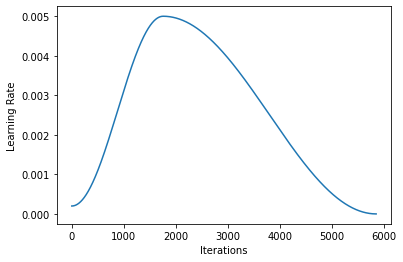

In [26]:
learner.recorder.plot_lr()

### Lets look at the evaluation metrics of the model

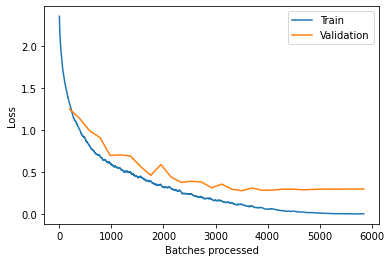

In [27]:
learner.recorder.plot_losses()

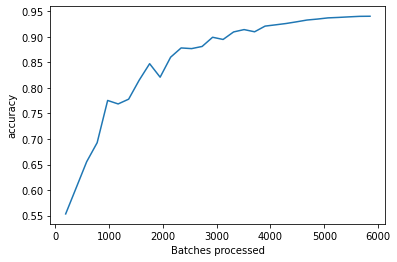

In [28]:
learner.recorder.plot_metrics()

## Lets save the model weights for future use
---
Coolio bai

In [0]:
torch.save(model.state_dict(), 'cifar10-wrn22.pth')